In [1]:
import scanpy as sc
import pandas as pd
import os
import scipy.sparse
import numpy as np

## Test neurips

### Read in adata that is used to create the embedding

In [2]:
cell_type_key = 'l2_cell_type'

In [3]:
data_path = "/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data"

In [4]:
adata = sc.read(
    os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'), backed='r')

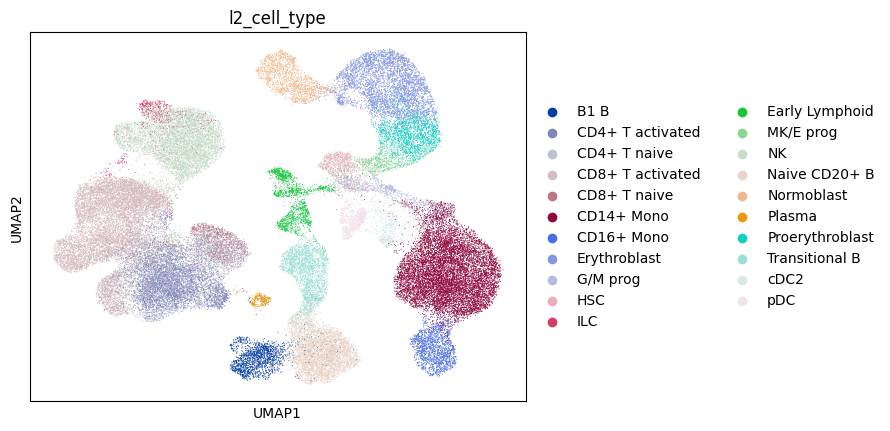

In [5]:
sc.pl.umap(adata, color='l2_cell_type')

### Read in adatas that contain the profiles

In [6]:
sample = 'merged'

In [7]:
adata_plus = sc.read(os.path.join(data_path, 'scooby_training_data', f'snapatac_{sample}_plus.h5ad'))

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
adata_minus = sc.read(os.path.join(data_path, 'scooby_training_data', f'snapatac_{sample}_minus.h5ad'))

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
adata_atac = sc.read(os.path.join(data_path, 'scooby_training_data', f'snapatac_{sample}_atac.h5ad'))

/opt/modules/i12g/anaconda/envs/borzoi-pytorch/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Read in neighbors and embedding

In [15]:
neighbors = scipy.sparse.load_npz(os.path.join(data_path, 'scooby_training_data', 'neighbors_100_no_val_genes_new.npz'))
embedding = pd.read_parquet(os.path.join(data_path, 'scooby_training_data', 'embedding_no_val_genes_new.pq'))

### Read in cell type to idx mapping

In [16]:
celltypes = pd.read_parquet(os.path.join(data_path, 'scooby_training_data', 'celltype_fixed.pq'))

### Test that adata, and profile adata have the same order

In [17]:
assert (adata.obs_names == adata_plus.obs_names).all()

In [18]:
assert (adata.obs_names == adata_minus.obs_names).all()

In [19]:
assert (adata.obs_names == adata_atac.obs_names).all()

### Test that profile adatas are correct

In [20]:
# test that adata_plus has positive values and not too large
assert (adata_plus.obsm['fragment_single'].data < 0).any() == False

In [21]:
adata_plus.obsm['fragment_single'].data.max()

105

In [22]:
# test that adata_minus has negative values not too small
assert (adata_minus.obsm['fragment_single'].data > 0).any() == False

In [23]:
adata_minus.obsm['fragment_single'].data.min()

-105

### Test that embeddings have the correct order

In [24]:
assert (embedding.obs_names == adata_plus.obs_names).all()

### Test that neighbors have the correct shape

In [25]:
assert neighbors.shape[0] == adata_plus.shape[0]

### Test that neighbors have the same cell type

In [34]:
np.random.seed(0)

In [35]:
for idx in np.random.choice(np.arange(adata.shape[0]), 10):
    print(adata_plus[idx].obs[cell_type_key].item())
    n = neighbors[idx].nonzero()[1]

    # check that the cell type of the cell is the most abundant cell type among the neighbors
    
    if not adata_plus[n].obs[cell_type_key].value_counts().index[0] == adata_plus[idx].obs[cell_type_key].item() :
        print(adata_plus[n].obs[cell_type_key].value_counts())

CD4+ T activated
NK
CD8+ T activated
Proerythroblast
HSC
HSC
CD8+ T naive
CD4+ T activated
Naive CD20+ B
CD8+ T activated


In [36]:
for idx in np.random.choice(np.arange(adata.shape[0]), 10):
    print(adata_minus[idx].obs[cell_type_key].item())
    n = neighbors[idx].nonzero()[1]

    # check that the cell type of the cell is the most abundant cell type among the neighbors
    
    if not adata_minus[n].obs[cell_type_key].value_counts().index[0] == adata_minus[idx].obs[cell_type_key].item() :
        print(adata_minus[n].obs[cell_type_key].value_counts())

CD14+ Mono
CD4+ T activated
Normoblast
CD8+ T naive
Proerythroblast
B1 B
CD8+ T naive
l2_cell_type
CD4+ T naive        56
CD8+ T naive        42
CD4+ T activated     1
CD8+ T activated     1
Name: count, dtype: int64
Erythroblast
pDC
Proerythroblast


In [37]:
for idx in np.random.choice(np.arange(adata.shape[0]), 10):
    print(adata_atac[idx].obs[cell_type_key].item())
    n = neighbors[idx].nonzero()[1]

    # check that the cell type of the cell is the most abundant cell type among the neighbors
    
    if not adata_atac[n].obs[cell_type_key].value_counts().index[0] == adata_atac[idx].obs[cell_type_key].item() :
        print(adata_atac[n].obs[cell_type_key].value_counts())

Naive CD20+ B
Naive CD20+ B
pDC
Early Lymphoid
CD16+ Mono
CD14+ Mono
l2_cell_type
CD4+ T activated    73
CD4+ T naive        21
CD8+ T activated     6
Name: count, dtype: int64
CD4+ T activated
CD16+ Mono
CD16+ Mono
pDC


## Test that celltypes index are correct

In [38]:
for i, row in celltypes.iterrows():
    print(row['celltype'])
    assert adata_plus[row['cellindex']].obs[cell_type_key].unique() == row['celltype']

Naive CD20+ B
CD14+ Mono
CD8+ T activated
CD16+ Mono
B1 B
Early Lymphoid
CD4+ T naive
CD4+ T activated
Erythroblast
NK
Transitional B
Normoblast
ILC
G/M prog
MK/E prog
HSC
pDC
Plasma
Proerythroblast
cDC2
CD8+ T naive


In [39]:
for i, row in celltypes.iterrows():
    print(row['celltype'])
    assert adata_minus[row['cellindex']].obs[cell_type_key].unique() == row['celltype']

Naive CD20+ B
CD14+ Mono
CD8+ T activated
CD16+ Mono
B1 B
Early Lymphoid
CD4+ T naive
CD4+ T activated
Erythroblast
NK
Transitional B
Normoblast
ILC
G/M prog
MK/E prog
HSC
pDC
Plasma
Proerythroblast
cDC2
CD8+ T naive


In [40]:
for i, row in celltypes.iterrows():
    print(row['celltype'])
    assert adata_atac[row['cellindex']].obs[cell_type_key].unique() == row['celltype']

Naive CD20+ B
CD14+ Mono
CD8+ T activated
CD16+ Mono
B1 B
Early Lymphoid
CD4+ T naive
CD4+ T activated
Erythroblast
NK
Transitional B
Normoblast
ILC
G/M prog
MK/E prog
HSC
pDC
Plasma
Proerythroblast
cDC2
CD8+ T naive
